In [11]:
import geopandas
import contextily as cx
import warnings
import pandas as pd
import math
warnings.filterwarnings('ignore')

In [12]:
import os
import sys
sys.path[0] = os.path.join(os.path.abspath(''),'..')

In [13]:
import data_pipeline.spatial_operations as so

In [14]:
# import fcc geojson
fcc_df = geopandas.read_file("/tmp/internet-access-map/data/broadband.geojson")
fcc_df.head()

,geoid,n_isp,n_dn10,n_dn100,n_dn250,n_fiber_100u,fiber_100u_exists,max_dn,max_up,f_broadband,...,population,households,tests,devices,d_mbps,u_mbps,lat_ms,tests_per_cap,devices_per_cap,geometry
0,34005702808,2.143,2.143,1.000,1.000,0.000,0.000,1000.000,35.000,0.910,...,3353.0,1055.0,31.62,20.18,305.57,20.75,14.66,0.009,0.006,"POLYGON ((-74.90801 40.03250, -74.90496 40.036..."
1,39153504200,3.286,2.457,1.000,1.000,0.000,0.000,940.000,35.000,0.634,...,1708.0,694.0,48.11,19.26,162.57,12.29,27.06,0.028,0.011,"POLYGON ((-81.51807 41.05957, -81.51805 41.062..."
2,36071000502,2.857,2.776,1.939,1.939,0.939,0.939,940.000,828.265,0.508,...,3763.0,1204.0,33.07,23.37,267.28,76.41,12.45,0.009,0.006,"POLYGON ((-74.02226 41.49281, -74.02180 41.496..."
3,06013370000,3.840,3.693,2.680,1.613,0.747,0.747,875.333,784.667,0.925,...,2850.0,1137.0,289.57,60.46,261.09,127.88,12.62,0.102,0.021,"POLYGON ((-122.32697 37.93502, -122.32611 37.9..."
4,48113019204,2.714,2.590,1.638,1.619,0.619,0.619,977.143,632.381,0.890,...,10051.0,2718.0,320.81,127.74,246.56,108.10,17.63,0.032,0.013,"POLYGON ((-96.76903 32.94655, -96.76899 32.950..."


In [83]:
''' The function figure 1 plots figure 1
    input: city_name - name of city
           neighborhoods_df - geopandas dataframe of shape file that contains neighborhood info for city
           census_tracts - pandas dataframe of csv file that contains census tracts for city
           tract_column - column in census tracts dataframe that corresponds to tract ID in fcc_df
           neighborhood_column - column in neighborhoods_df that contains to neighborhood IDs
           geometry_column - column in neighborhoods_df that has polygons of neighborhoods (automatically set to geometry)
    output: figure 1 plot
'''
def figure1(city_name, neighborhoods_df, census_tracts, tract_column, neighborhood_column, geometry_column='geometry'):
    # pull out a list of indexes:
    indexes = []
    for tract in census_tracts[tract_column]:
        if city_name == "Albuquerque":
            temp = fcc_df.loc[fcc_df["geoid"] == str(tract)[7:]].index.values
        elif city_name == "Denver":
            temp = fcc_df['geoid'].isin([("0" + str(tract))])
        else:
            temp = fcc_df['geoid'].isin([str(tract)])
        if True in list(temp):
            loc = list(temp).index(True)
            indexes.append(loc)
                          
    local_fcc_df = fcc_df.loc[indexes]
    so.simple_map(local_fcc_df, 'f_broadband', 'geoid', city_name + ' broadband by census tract')
                          
    neighborhoods = {}
    indexes = []
    for i, poly in enumerate(local_fcc_df[geometry_column]):
        for j, nhood in enumerate(neighborhoods_df[geometry_column]):
            if nhood.intersects(poly) or nhood.contains(poly):
                temp = neighborhoods.get(j, [])
                temp.append(i)
                neighborhoods[j] = temp
    
    if len(neighborhoods) != neighborhoods_df.shape[0]:
        missing = []
        i = 0
        while i < len(neighborhoods):
            if i not in neighborhoods:
                missing.append(i)
            i += 1
        
        neighborhoods_df = neighborhoods_df.drop(missing)
    
    normal_avgs = []
    bband = list(local_fcc_df['f_broadband'])
    for key, val in neighborhoods.items():
        s = 0
        if len(neighborhoods) != neighborhoods_df.shape[0]:
            if i in set(neighborhoods):
                for j in val:
                    if not math.isnan(bband[j]):
                        s = s + float(bband[j])
                normal_avgs.append(s/len(val))
            else:
                normal_avgs.append(None)
        else:
            for j in val:
                if not math.isnan(bband[j]):
                    s = s + float(bband[j])
            normal_avgs.append(s/len(val))
    
    neighborhoods_df['broadband_avg'] = normal_avgs
                          
    so.simple_map(neighborhoods_df, 'broadband_avg', neighborhood_column, city_name + ' broadband by Neighborhood Boundary')

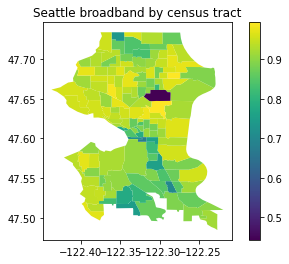

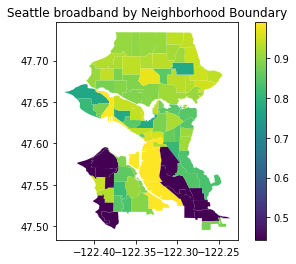

In [84]:
# Using figure 1 function to find Seattle Figure 1
seattle_df = geopandas.read_file("/tmp/neighborhood-data/seattle/seattle_ccn/City_Clerk_Neighborhoods.shp")
seattle_census = pd.read_csv("/tmp/neighborhood-data/seattle/Census_Tracts_2010.csv")
figure1('Seattle', seattle_df, seattle_census, 'GEOID10', 'HOODS_')

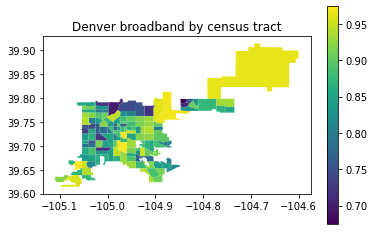

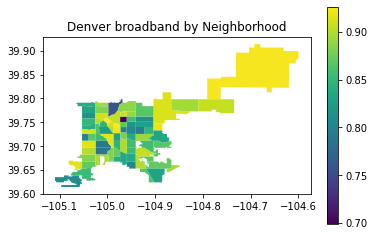

In [58]:
# Using figure 1 function to find Denver Figure 1
denver_df = geopandas.read_file("/tmp/neighborhood-data/denver/denver_1.0.32/statistical_neighborhoods.shp")
denver_census = pd.read_csv("/tmp/neighborhood-data/denver/denver_census_tracts_2010.csv")
figure1('Denver', denver_df, denver_census, 'GEOID_TRACT', 'NBHD_NAME')

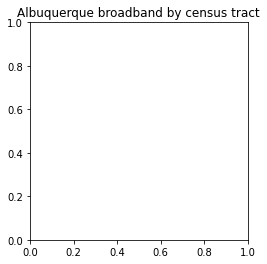

ValueError: Length of values (0) does not match length of index (300)

In [78]:
# Using figure 1 function to find Albuquerque Figure 1
alb_df = geopandas.read_file("/tmp/neighborhood-data/albuquerque/albuquerque-shp/nbr.shp")
alb_df_trans = alb_df.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})
alb_census = pd.read_csv("/tmp/neighborhood-data/albuquerque/alb-census.csv")
figure1('Albuquerque', alb_df_trans, alb_census, "ID Geography", 'Associatio')

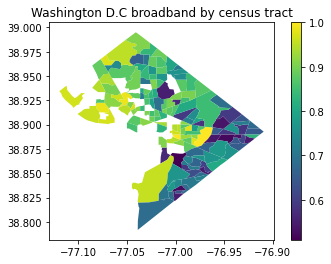

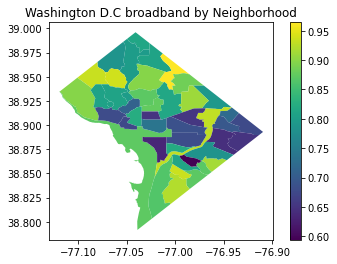

In [60]:
# Using figure 1 function to find Washington D.C. Figure 1
dc_df = geopandas.read_file("/tmp/neighborhood-data/washington-dc/DC_shapefile/Neighborhood_Clusters.shp")
dc_census = pd.read_csv("/tmp/neighborhood-data/washington-dc/washington-dc-census-tract.csv")
figure1('Washington D.C', dc_df, dc_census, 'GEOID', 'OBJECTID')

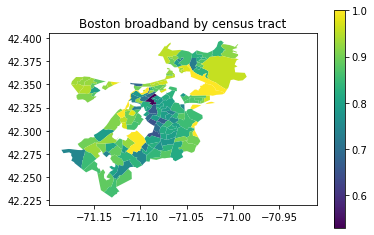

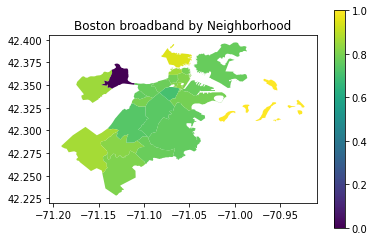

In [70]:
# Using figure 1 function to find Boston Figure 1
boston_df = geopandas.read_file("/tmp/neighborhood-data/boston/Boston_Neighborhoods/Boston_Neighborhoods.shp")
boston_census = pd.read_csv("/tmp/neighborhood-data/boston/boston-census.csv")
figure1('Boston', boston_df, boston_census, 'GEOCODE', 'Neighborho')

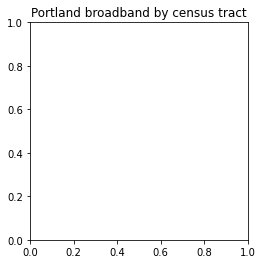

ValueError: Length of values (0) does not match length of index (130)

In [74]:
# Using figure 1 function to find Portland Figure 1
portland_df = geopandas.read_file("/tmp/neighborhood-data/portland/portland-neighborhood-boundaries/Neighborhood_Boundaries.shp")
portland_census = pd.read_csv("/tmp/neighborhood-data/portland/portland-census.csv")
portland_df_trans = portland_df.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})
figure1('Portland', portland_df_trans, portland_census, 'ID Geography', 'OBJECTID')
